# Propensy Score

In [19]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd, numpy as np, matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr

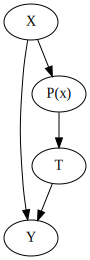

In [20]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("X", "P(x)")
g.edge("P(x)", "T")
g

# pasos

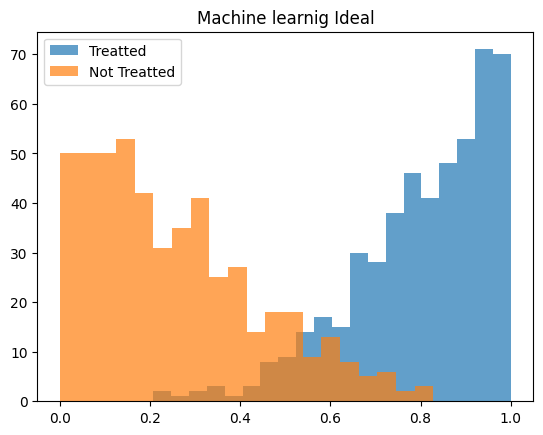

In [13]:
np.random.seed(1)
x_treat_pred = np.random.beta(4, 1, 500)
x_contl_pred = np.random.beta(1, 3, 500)
plt.hist(x_treat_pred, alpha = .7, bins=20, label = "Treatted")
plt.hist(x_contl_pred, alpha = .7, bins=20, label = "Not Treatted")
plt.title("Machine learnig Ideal")
plt.legend();

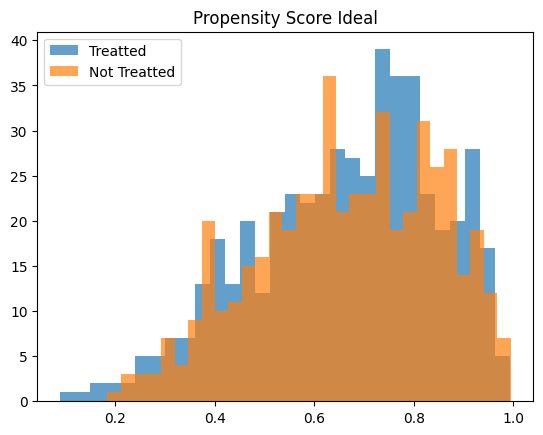

In [17]:
np.random.seed(1)
x_treat_pred = np.random.beta(4, 2, 500)
x_contl_pred = np.random.beta(4, 2, 500)
plt.hist(x_treat_pred, alpha = .7, bins=30, label = "Treatted")
plt.hist(x_contl_pred, alpha = .7, bins=30, label = "Not Treatted")
plt.title("Propensity Score Ideal")
plt.legend();

In [2]:
data = pd.read_csv("https://github.com/matheusfacure/python-causality-handbook/raw/master/causal-inference-for-the-brave-and-true/data/learning_mindset.csv")
data.shape
data.head()

,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
0,76,1,0.277359,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
1,76,1,-0.449646,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
2,76,1,0.769703,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
3,76,1,-0.121763,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
4,76,1,1.526147,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757


In [3]:
smf.ols("achievement_score ~ intervention", data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1538,0.012,-13.201,0.000,-0.177,-0.131
intervention,0.4723,0.020,23.133,0.000,0.432,0.512


In [4]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False)# categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


In [5]:
from sklearn.linear_model import LogisticRegression

T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

ps_model = LogisticRegression(C=1e6).fit(data_with_categ[X], data_with_categ[T])

data_ps = data.assign(ps=ps_model.predict_proba(data_with_categ[X])[:, 1])

data_ps[["intervention", "achievement_score", "ps"]].head()

,intervention,achievement_score,ps
0,1,0.277359,0.315467
1,1,-0.449646,0.263620
2,1,0.769703,0.344030
3,1,-0.121763,0.344030
4,1,1.526147,0.367824


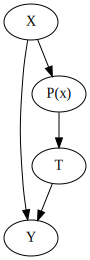

In [6]:
import graphviz as gr
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("X", "P(x)")
g.edge("P(x)", "T")
g

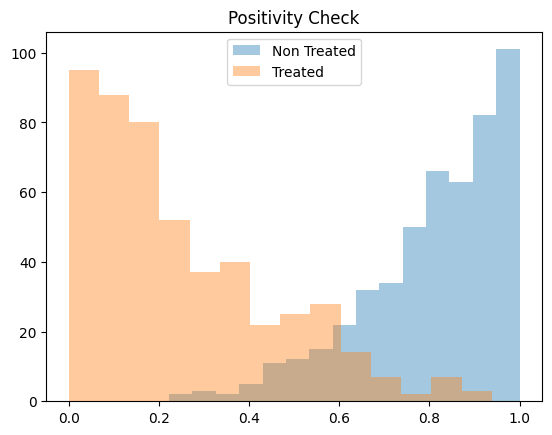

In [7]:
import seaborn as sns, numpy as np, matplotlib.pyplot as plt
sns.distplot(np.random.beta(4,1,500), kde=False, label="Non Treated")
sns.distplot(np.random.beta(1,3,500), kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

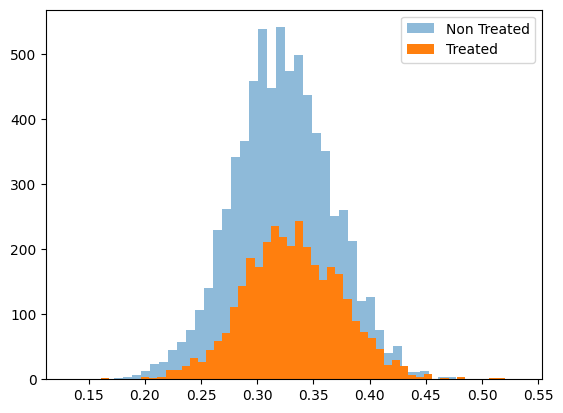

In [32]:
cl = np.unique(data_ps.intervention)
cl_lbl = ["Non Treated", "Treated"]
for i in range(2):
    plt.hist(data_ps[data_ps.intervention == cl[i]].ps, 50, label = cl_lbl[i], alpha = .5)

plt.legend();
# plt.hist(data_ps.ps, 100)

In [9]:
weight_t = 1/data_ps.query("intervention==1")["ps"]
weight_nt = 1/(1-data_ps.query("intervention==0")["ps"])
print("Original Sample Size", data.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 10391
Treated Population Sample Size 10388.745938098658
Untreated Population Sample Size 10391.407891472618


In [10]:
def get_info(data_0, treat = "intervention", ps = "ps"):
    weight = ((data_0[treat]-data_0[ps]) /
          (data_0[ps]*(1-data_0[ps])))

    y1 = sum(data_0.query(f"{treat}==1")["achievement_score"]*weight_t) / len(data)
    y0 = sum(data_0.query(f"{treat}==0")["achievement_score"]*weight_nt) / len(data)

    ate = np.mean(weight * data_0["achievement_score"])

    print("Y1:", y1)
    print("Y0:", y0)
    print("ATE", np.mean(weight * data_0["achievement_score"]))
get_info(data_ps)

Y1: 0.2595686019780058
Y0: -0.1289117322808988
ATE 0.38848033425890455


In [36]:
from causalinference import CausalModel

In [39]:
cm = CausalModel(
    Y=data_ps["achievement_score"].values, 
    D=data_ps["intervention"].values, 
    X=data_ps[["ps"]].values
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.380      0.025     15.067      0.000      0.331      0.430
           ATC      0.373      0.028     13.415      0.000      0.318      0.427
           ATT      0.396      0.027     14.734      0.000      0.344      0.449



In [34]:
data_ps.to_stata("sch.dta")

# Ejemplo simple

In [13]:
sample = pd.read_csv("https://github.com/cerquide/propensity_score_talk/blob/main/sample?raw=true")
sample.to_stata("sample.dta")

In [15]:
from sklearn.linear_model import LogisticRegression

In [17]:
sample.head()

,smoker,treatment,dead
0,0,0,0
1,1,1,0
2,1,1,0
3,0,1,0
4,0,0,0


In [22]:
pd.to_numeric(sample.smoker)

0         0
1         1
2         1
3         0
4         0
         ..
999995    0
999996    1
999997    0
999998    0
999999    0
Name: smoker, Length: 1000000, dtype: int64

In [28]:
t = 'treatment'
y = 'dead'
x = 'smoker'
X = pd.to_numeric(sample.smoker)
# X = data_with_categ.columns.drop(['schoolid', T, Y])

ps_model = LogisticRegression(C=1e6).fit(pd.to_numeric(X), sample[y])

# sample_ps = sample.assign(p_s=ps_model.predict_proba(ps_model))

# data_ps[["intervention", "achievement_score", "propensity_score"]].head()

ValueError: Expected 2D array, got 1D array instead:
array=[0. 1. 1. ... 0. 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.